In [1]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/e3pqxcIznqdYyRv/Dataset_Specific_labelled.h5

--2024-07-10 10:06:25--  https://cernbox.cern.ch/remote.php/dav/public-files/e3pqxcIznqdYyRv/Dataset_Specific_labelled.h5

Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 128.142.170.17, ...

Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.

HTTP request sent, awaiting response... 200 OK

Length: 5000042048 (4.7G) [application/octet-stream]

Saving to: 'Dataset_Specific_labelled.h5'



Dataset_Specific_la 100%[===================>]   4.66G  9.12MB/s    in 11m 5s  



2024-07-10 10:17:51 (7.17 MB/s) - 'Dataset_Specific_labelled.h5' saved [5000042048/5000042048]




In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

class ChebyshevKANLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, degree, device):
        super(ChebyshevKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree
        self.device = device

        self.cheby_coeffs = torch.nn.Parameter(torch.empty(input_dim, output_dim, degree + 1).to(device))
        torch.nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1).to(device))

    def chebyshev_polynomials(self, x):
        T = [torch.ones_like(x).to(self.device), 2 * x]
        for n in range(2, self.degree + 1):
            T.append(2 * x * T[n - 1] - T[n - 2])
        return torch.stack(T, dim=-1)

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()
        x = x.view(-1, self.inputdim)
        x = torch.tanh(x)
        T = self.chebyshev_polynomials(x)
        y = torch.einsum("bij,ioj->bo", T, self.cheby_coeffs)
        y = y.view(batch_size, seq_length, self.outdim)
        return y

class MultiheadKANAttention(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, rotation_matrix, degree=3, device='cpu'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.position_emb = rotation_matrix.to(device)
        self.device = device

        self.q_linear = ChebyshevKANLayer(hidden_size, hidden_size, degree, device)
        self.kv_linear = ChebyshevKANLayer(hidden_size, hidden_size * 2, degree, device)
        self.out = torch.nn.Linear(hidden_size, hidden_size).to(device)

    def forward(self, x, memory=None):
        batch_size, seq_length, _ = x.size()
        if memory is None:
            q = self.q_linear(x)
            kv = self.kv_linear(x)
            q = q.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
            kv = kv.reshape(batch_size, -1, self.num_heads, 2 * self.head_dim)
            queries = q.transpose(1, 2)
            kv = kv.transpose(1, 2)
            keys, values = kv.chunk(2, dim=-1)
        else:
            q = self.q_linear(x)
            kv = self.kv_linear(memory)
            q = q.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
            kv = kv.reshape(batch_size, -1, self.num_heads, 2 * self.head_dim)
            queries = q.transpose(1, 2)
            kv = kv.transpose(1, 2)
            keys, values = kv.chunk(2, dim=-1)

        queries = apply_rotary_pos_emb(queries, self.position_emb)
        keys = apply_rotary_pos_emb(keys, self.position_emb)

        scores = torch.matmul(queries, keys.transpose(2, 3))
        scores = scores / (self.head_dim ** 0.5)
        attention = F.softmax(scores, dim=-1)
        context = torch.matmul(attention, values)
        context = context.transpose(1, 2).contiguous()
        context = context.reshape(batch_size, seq_length, self.hidden_size)
        output = self.out(context)

        return output

class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, rotation_matrix, degree=3, device='cpu'):
        super().__init__()
        self.norm1 = RMSNorm(hidden_size, device=device)
        self.attention = MultiheadKANAttention(hidden_size, num_heads, rotation_matrix, degree, device)
        self.norm2 = RMSNorm(hidden_size, device=device)
        self.ff = ChebyshevKANLayer(hidden_size, hidden_size, degree, device)

    def forward(self, x):
        x1 = self.attention(self.norm1(x))
        x = x + x1
        x2 = self.ff(self.norm2(x))
        x = x + x2
        return x

class TransformerDecoderLayer(torch.nn.Module):
    def __init__(self, hidden_size, num_heads, rotation_matrix, degree=3, device='cpu'):
        super().__init__()
        self.norm1 = RMSNorm(hidden_size, device=device)
        self.self_attention = MultiheadKANAttention(hidden_size, num_heads, rotation_matrix, degree, device)
        self.norm2 = RMSNorm(hidden_size, device=device)
        self.cross_attention = MultiheadKANAttention(hidden_size, num_heads, rotation_matrix, degree, device)
        self.norm3 = RMSNorm(hidden_size, device=device)
        self.ff = ChebyshevKANLayer(hidden_size, hidden_size, degree, device)

    def forward(self, x, enc_output):
        x1 = self.self_attention(self.norm1(x))
        x = x + x1
        x2 = self.cross_attention(self.norm2(x), enc_output)
        x = x + x2
        x3 = self.ff(self.norm3(x))
        x = x + x3
        return x

class RMSNorm(torch.nn.Module):
    def __init__(self, hidden_size: int, eps: float = 1e-6, device='cpu'):
        super().__init__()
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(hidden_size).to(device))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class RotaryPositionalEmbedding(torch.nn.Module):
    def __init__(self, dim, max_seq_len, device='cpu'):
        super(RotaryPositionalEmbedding, self).__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (1000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq.to(device))
        self.register_buffer('pos_enc', self._generate_positional_encoding(max_seq_len, device))

    def _generate_positional_encoding(self, seq_len, device):
        t = torch.arange(seq_len, device=device, dtype=self.inv_freq.dtype)
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        pos_enc = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        return pos_enc

    def forward(self, seq_len):
        return self.pos_enc[:seq_len, :]

def apply_rotary_pos_emb(x, pos_emb):
    x_cos, x_sin = torch.split(pos_emb, x.shape[-1] // 2, dim=-1)
    x1_rot = (x[..., ::2] * x_cos) + (rotate_half(x[..., 1::2]) * x_sin)
    x2_rot = (x[..., 1::2] * x_cos) + (rotate_half(x[..., ::2]) * x_sin)
    x_rot = torch.cat([x1_rot, x2_rot], dim=-1)
    return x_rot

def rotate_half(x):
    x1, x2 = torch.chunk(x, 2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

class TransformerEncoder(torch.nn.Module):
    def __init__(self, num_layers, num_features, hidden_size, num_heads, max_seq_len, degree=3, device='cpu'):
        super().__init__()
        self.embedding = torch.nn.Linear(num_features, hidden_size).to(device)
        head_dim = hidden_size // num_heads
        rope = RotaryPositionalEmbedding(head_dim, max_seq_len, device)
        self.rotation_matrix = rope(max_seq_len)
        self.layers = torch.nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, self.rotation_matrix, degree, device)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        return x

class TransformerDecoder(torch.nn.Module):
    def __init__(self, num_layers, num_features, hidden_size, num_heads, max_seq_len, degree=3, device='cpu'):
        super().__init__()
        self.embedding = torch.nn.Linear(num_features, hidden_size).to(device)
        head_dim = hidden_size // num_heads
        rope = RotaryPositionalEmbedding(head_dim, max_seq_len, device)
        self.rotation_matrix = rope(max_seq_len)
        self.layers = torch.nn.ModuleList([
            TransformerDecoderLayer(hidden_size, num_heads, self.rotation_matrix, degree, device)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_output):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, enc_output)
        return x

class Transformer(torch.nn.Module):
    def __init__(self, in_channels, num_encoder_layers, num_decoder_layers, num_features, hidden_size, num_heads, max_seq_len, degree=3, device='cpu'):
        super().__init__()
        self.encoder = TransformerEncoder(num_encoder_layers, num_features, hidden_size, num_heads, max_seq_len, degree, device)
        self.decoder = TransformerDecoder(num_decoder_layers, num_features, hidden_size, num_heads, max_seq_len, degree, device)
        self.output_layer = torch.nn.Linear(hidden_size, num_features).to(device)
        self.in_channels = in_channels
        self.device = device

    def forward(self, src):
        channels = src.chunk(self.in_channels, dim=1)
        outputs = []
        for channel in channels:
            channel = channel.squeeze(1)
            enc_output = self.encoder(channel)
            dec_output = self.decoder(channel, enc_output)
            outputs.append(self.output_layer(dec_output))
        return torch.stack(outputs, dim=1)


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py as h5
import torch.nn as nn
import torch.optim as optim

class MyDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        f = h5.File(h5_path, 'r')
        self.jet = f['jet']
        self.Y = f['Y']
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        data = torch.from_numpy(self.jet[idx]).moveaxis(2, 0) / 255
        label = torch.from_numpy(self.Y[idx])
        return data, label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dset = MyDataset('/kaggle/working/Dataset_Specific_labelled.h5')
dataloader = DataLoader(dset, batch_size=32, shuffle=True)

channels = 8
height = 125
width = 125

model = Transformer(
    in_channels=channels,
    num_encoder_layers=2,
    num_decoder_layers=2,
    num_features=height, 
    hidden_size=256,
    num_heads=4,
    max_seq_len=height,
    degree=3,
    device=device
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        output = model(data)
        output = torch.sigmoid(output)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    average_epoch_loss = epoch_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}')

model.eval()
with torch.no_grad():
    for batch_idx, (test_data, _) in enumerate(dataloader):
        test_data = test_data.to(device)  # Move test data to GPU
        reconstructed = model(test_data)
        reconstructed = torch.sigmoid(reconstructed)
        reconstruction_loss = criterion(reconstructed, test_data)
        print(f'Reconstruction Loss for batch {batch_idx+1}: {reconstruction_loss.item():.4f}')


Epoch [1/20], Loss: 0.0282

Epoch [2/20], Loss: 0.0107

Epoch [3/20], Loss: 0.0071

Epoch [4/20], Loss: 0.0059

Epoch [5/20], Loss: 0.0053

Epoch [6/20], Loss: 0.0051

Epoch [7/20], Loss: 0.0049

Epoch [8/20], Loss: 0.0048

Epoch [9/20], Loss: 0.0047

Epoch [10/20], Loss: 0.0046

Epoch [11/20], Loss: 0.0046

Epoch [12/20], Loss: 0.0045

Epoch [13/20], Loss: 0.0045

Epoch [14/20], Loss: 0.0044

Epoch [15/20], Loss: 0.0044

Epoch [16/20], Loss: 0.0044

Epoch [17/20], Loss: 0.0043

Epoch [18/20], Loss: 0.0043

Epoch [19/20], Loss: 0.0043

Epoch [20/20], Loss: 0.0043

Reconstruction Loss for batch 1: 0.0041

Reconstruction Loss for batch 2: 0.0043

Reconstruction Loss for batch 3: 0.0042

Reconstruction Loss for batch 4: 0.0041

Reconstruction Loss for batch 5: 0.0042

Reconstruction Loss for batch 6: 0.0041

Reconstruction Loss for batch 7: 0.0041

Reconstruction Loss for batch 8: 0.0042

Reconstruction Loss for batch 9: 0.0039

Reconstruction Loss for batch 10: 0.0047

Reconstruction Los

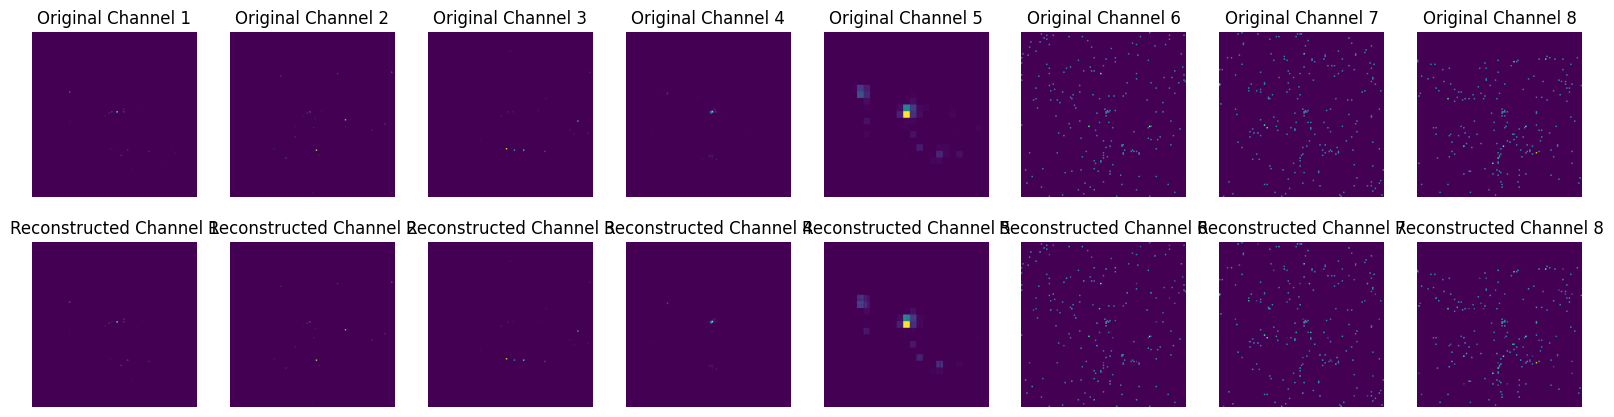

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract a batch of data
sample_batch = next(iter(dataloader))
original_data, _ = sample_batch
original_data = original_data.to(device)

# Run the model to get the reconstructed data
model.eval()
with torch.no_grad():
    reconstructed_data = model(original_data)
    reconstructed_data = torch.sigmoid(reconstructed_data)

# Move data back to CPU for plotting
original_data = original_data.cpu().numpy()
reconstructed_data = reconstructed_data.cpu().numpy()

# Function to plot original and reconstructed channels
def plot_original_vs_reconstructed(original, reconstructed, num_channels=8):
    fig, axes = plt.subplots(2, num_channels, figsize=(20, 5))
    for i in range(num_channels):
        # Plot original
        axes[0, i].imshow(original[i], cmap='viridis')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original Channel {i+1}')
        
        # Plot reconstructed
        axes[1, i].imshow(reconstructed[i], cmap='viridis')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Reconstructed Channel {i+1}')
    
    plt.show()

original_image = original_data[0]
reconstructed_image = reconstructed_data[0]
plot_original_vs_reconstructed(original_image, reconstructed_image, num_channels=8)